<a href="https://colab.research.google.com/github/priyanshu3489/Deepfake-detection-/blob/main/prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 48.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import cv2
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_cv.layers import RandomRotation

In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 📁 Load Dataset
# ================================
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/videos_labels.csv'
df = pd.read_csv(dataset_path)

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 721
Validation set size: 241
Test set size: 241


**Run once, no more now**

In [ ]:
def move_videos(video_dict, fake_folder, real_folder, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for video_id, label in video_dict.items():
        video_file = os.path.join(fake_folder if label == 0 else real_folder, f"{video_id}.mp4")
        if os.path.isfile(video_file):
            shutil.copy(video_file, destination_folder)

# Move Train
move_videos(dict(zip(train_df['video_id'], train_df['label'])),
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/fake',
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/real',
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/train_df_videos')

# Move Val
move_videos(dict(zip(val_df['video_id'], val_df['label'])),
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/fake',
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/real',
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/val_df_videos')

# Move Test
move_videos(dict(zip(test_df['video_id'], test_df['label'])),
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/fake',
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/real',
            '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/test_df_videos')

# **Frame Extraction**

In [ ]:
def load_frames(video_id, frames_dir, num_frames, img_size):
    video_path = os.path.join(frames_dir, f"{video_id}.mp4")
    cap = cv2.VideoCapture(video_path)
    frames, frame_count = [], int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(frame_count // num_frames, 1)
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame, img_size)
        frames.append(frame)
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8))
    return np.array(frames[:num_frames])

def create_dataset(df, frames_dir, num_frames=25, img_size=(224, 224)):
    X, y = [], []
    for _, row in df.iterrows():
        try:
            X.append(load_frames(row['video_id'], frames_dir, num_frames, img_size))
            y.append(row['label'])
        except Exception as e:
            print(f"Error loading frames for {row['video_id']}: {e}")
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_df, '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/train_df_videos')
X_val, y_val = create_dataset(val_df, '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/val_df_videos')
X_test, y_test = create_dataset(test_df, '/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/test_df_videos')


In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (721, 25, 224, 224, 3), y_train shape: (721,)
X_val shape: (241, 25, 224, 224, 3), y_val shape: (241,)
X_test shape: (241, 25, 224, 224, 3), y_test shape: (241,)


# **CNN_Bi-LSTM_Model.h5**

In [ ]:
def create_cnn_lstm_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    model = Sequential()
    model.add(TimeDistributed(base_model, input_shape=input_shape))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Data Augmentation
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = RandomRotation(0.1)(image)
    return image, label



In [ ]:
input_shape = (25, 224, 224, 3)
model = create_cnn_lstm_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 2
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(augment_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[checkpoint])



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6406 - loss: 0.6839

361/361 ━━━━━━━━━━━━━━━━━━━━ 367s 502ms/step - accuracy: 0.6407 - loss: 0.6838 - val_accuracy: 0.7095 - val_loss: 0.5825
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6431 - loss: 0.6350

361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 343ms/step - accuracy: 0.6431 - loss: 0.6350 - val_accuracy: 0.7469 - val_loss: 0.5300
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 121s 334ms/step - accuracy: 0.7145 - loss: 0.5907 - val_accuracy: 0.6515 - val_loss: 0.6643
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7789 - loss: 0.5243

361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 344ms/step - accuracy: 0.7789 - loss: 0.5244 - val_accuracy: 0.8548 - val_loss: 0.4424
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 121s 335ms/step - accuracy: 0.8014 - loss: 0.5070 - val_accuracy: 0.7884 - val_loss: 0.4705
Epoch 6/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7863 - loss: 0.5038

361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 343ms/step - accuracy: 0.7863 - loss: 0.5038 - val_accuracy: 0.8382 - val_loss: 0.4357
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7601 - loss: 0.5036

361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 343ms/step - accuracy: 0.7601 - loss: 0.5036 - val_accuracy: 0.8340 - val_loss: 0.4009
Epoch 8/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 121s 335ms/step - accuracy: 0.8025 - loss: 0.4738 - val_accuracy: 0.8257 - val_loss: 0.4256
Epoch 9/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - accuracy: 0.7997 - loss: 0.4863 - val_accuracy: 0.7842 - val_loss: 0.5283
Epoch 10/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 337ms/step - accuracy: 0.7761 - loss: 0.5113 - val_accuracy: 0.8091 - val_loss: 0.4925
Epoch 11/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - accuracy: 0.8226 - loss: 0.4605 - val_accuracy: 0.8091 - val_loss: 0.4233
Epoch 12/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 337ms/step - accuracy: 0.8288 - loss: 0.4235 - val_accuracy: 0.7842 - val_loss: 0.5790
Epoch 13/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 123s 339ms/step - accuracy: 0.7868 - loss: 0.4800 - val_accuracy: 0.8133 - val_loss: 0.4635
Epoch 14/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 337ms/step - accuracy: 0.7973 - loss:

361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 344ms/step - accuracy: 0.7828 - loss: 0.4508 - val_accuracy: 0.8631 - val_loss: 0.3382
Epoch 20/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - accuracy: 0.7820 - loss: 0.4793 - val_accuracy: 0.8133 - val_loss: 0.4565
Epoch 21/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 336ms/step - accuracy: 0.7907 - loss: 0.4590 - val_accuracy: 0.8008 - val_loss: 0.6445
Epoch 22/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 337ms/step - accuracy: 0.8089 - loss: 0.4618 - val_accuracy: 0.7759 - val_loss: 0.5447
Epoch 23/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 337ms/step - accuracy: 0.8072 - loss: 0.4137 - val_accuracy: 0.8050 - val_loss: 0.4587
Epoch 24/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 128s 354ms/step - accuracy: 0.8349 - loss: 0.3780 - val_accuracy: 0.8091 - val_loss: 0.4239
Epoch 25/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 344ms/step - accuracy: 0.8467 - loss: 0.3732 - val_accuracy: 0.8340 - val_loss: 0.4163
Epoch 26/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 126s 349ms/step - accuracy: 0.8556 - los

361/361 ━━━━━━━━━━━━━━━━━━━━ 124s 344ms/step - accuracy: 0.8666 - loss: 0.3692 - val_accuracy: 0.8631 - val_loss: 0.3253
Epoch 28/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 337ms/step - accuracy: 0.8304 - loss: 0.3872 - val_accuracy: 0.8465 - val_loss: 0.4353
Epoch 29/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 122s 337ms/step - accuracy: 0.8605 - loss: 0.3359 - val_accuracy: 0.8423 - val_loss: 0.5501
Epoch 30/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 125s 346ms/step - accuracy: 0.8327 - loss: 0.4308 - val_accuracy: 0.8008 - val_loss: 0.4951


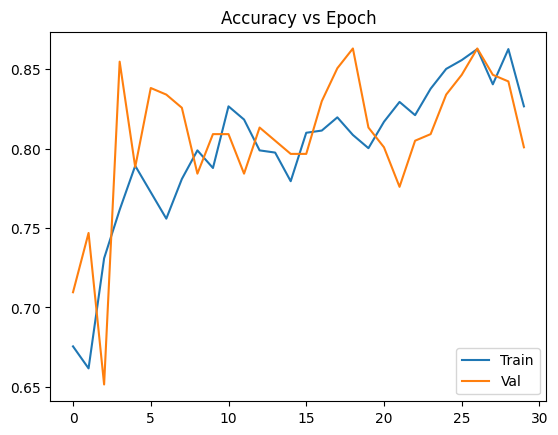

In [ ]:

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step

✅ Test Accuracy: 0.7718

📄 Classification Report:
              precision    recall  f1-score   support

        Fake       0.76      0.93      0.84       152
        Real       0.81      0.49      0.62        89

    accuracy                           0.77       241
   macro avg       0.79      0.71      0.73       241
weighted avg       0.78      0.77      0.76       241



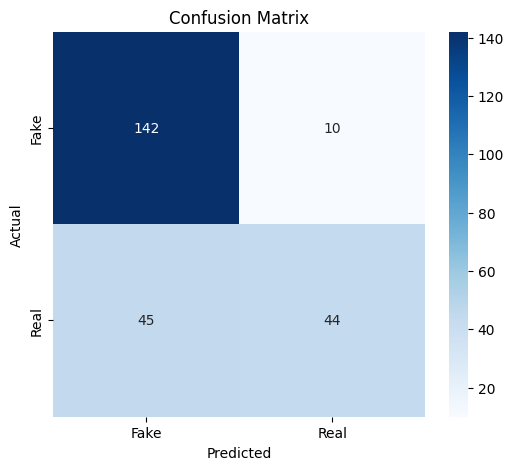

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# ================================
# 🧪 Model Evaluation on Test Set
# ================================

# Generate predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Accuracy and metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **ViT_Model.h5**

In [ ]:
!pip install transformers


In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Bidirectional, Dense, Dropout


In [ ]:
import tensorflow_hub as hub

vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"  # Vision Transformer Base 16x16 patch, feature extractor
vit_layer = hub.KerasLayer(vit_url, trainable=False)  # freeze by default


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K

# ===============================
# Custom Attention Layer
# ===============================
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

# ===============================
# ViT Feature Extractor Layer
# ===============================
class VitFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, vit_url="https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False, **kwargs):
        super(VitFeatureExtractor, self).__init__(**kwargs)
        self.vit = hub.KerasLayer(vit_url, trainable=trainable)

    def call(self, inputs):
        return self.vit(inputs)

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return (batch_size, 768)

# ===============================
# Model Architecture
# ===============================
def create_vit_lstm_attention_model(input_shape=(50, 224, 224, 3), num_classes=1):
    video_input = tf.keras.Input(shape=input_shape)

    # Optional: CNN pre-processing for local features
    cnn_block = tf.keras.Sequential([
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())
    ])

    x = cnn_block(video_input)

    # Vision Transformer Feature Extraction
    vit_layer = VitFeatureExtractor()
    x = tf.keras.layers.TimeDistributed(vit_layer)(video_input)

    # LSTM for temporal sequence modeling
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)

    # Attention mechanism
    x = AttentionLayer()(x)

    # Classification head
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=video_input, outputs=output)
    return model

# ===============================
# Custom Focal Loss
# ===============================
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow((1 - p_t), gamma)
        return -K.mean(alpha_factor * modulating_factor * K.log(p_t))
    return focal_loss

# ===============================
# Compile & Train the Model
# ===============================

# Define input shape
input_shape = (50, 224, 224, 3)

# Build model
model = create_vit_lstm_attention_model(input_shape=input_shape)

# Compile with focal loss
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=binary_focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

# Dataset loading (replace X_train, y_train, etc. with actual variables)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(4).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(4).prefetch(tf.data.AUTOTUNE)

# Callback for saving the best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('ViT_LSTM_Attention.h5',
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   verbose=1)

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=30,
                    callbacks=[checkpoint_cb])


Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6112 - loss: 0.0815
Epoch 1: val_accuracy improved from -inf to 0.69295, saving model to ViT_LSTM_Attention.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 125s 435ms/step - accuracy: 0.6113 - loss: 0.0814 - val_accuracy: 0.6929 - val_loss: 0.0590
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6558 - loss: 0.0668
Epoch 2: val_accuracy did not improve from 0.69295
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.6559 - loss: 0.0668 - val_accuracy: 0.6929 - val_loss: 0.0576
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6615 - loss: 0.0644
Epoch 3: val_accuracy improved from 0.69295 to 0.69710, saving model to ViT_LSTM_Attention.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.6615 - loss: 0.0644 - val_accuracy: 0.6971 - val_loss: 0.0614
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6572 - loss: 0.0661
Epoch 4: val_accuracy did not improve from 0.69710
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.6573 - loss: 0.0661 - val_accuracy: 0.6971 - val_loss: 0.0571
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6590 - loss: 0.0629
Epoch 5: val_accuracy did not improve from 0.69710
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.6590 - loss: 0.0629 - val_accuracy: 0.6971 - val_loss: 0.0581
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6665 - loss: 0.0614
Epoch 6: val_accuracy did not improve from 0.69710
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.6665 - loss: 0.0614 - val_accuracy: 0.6971 - val_loss: 0.0560
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6634 - loss: 0.0624
Epoch 7: val_ac

181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.6691 - loss: 0.0599 - val_accuracy: 0.7344 - val_loss: 0.0593
Epoch 11/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6972 - loss: 0.0616
Epoch 11: val_accuracy did not improve from 0.73444
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.6972 - loss: 0.0616 - val_accuracy: 0.7261 - val_loss: 0.0537
Epoch 12/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6872 - loss: 0.0584
Epoch 12: val_accuracy did not improve from 0.73444
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.6872 - loss: 0.0584 - val_accuracy: 0.7261 - val_loss: 0.0542
Epoch 13/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7032 - loss: 0.0584
Epoch 13: val_accuracy improved from 0.73444 to 0.73859, saving model to ViT_LSTM_Attention.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7032 - loss: 0.0584 - val_accuracy: 0.7386 - val_loss: 0.0530
Epoch 14/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7143 - loss: 0.0560
Epoch 14: val_accuracy improved from 0.73859 to 0.75934, saving model to ViT_LSTM_Attention.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7143 - loss: 0.0560 - val_accuracy: 0.7593 - val_loss: 0.0520
Epoch 15/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7251 - loss: 0.0555
Epoch 15: val_accuracy improved from 0.75934 to 0.77178, saving model to ViT_LSTM_Attention.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7250 - loss: 0.0555 - val_accuracy: 0.7718 - val_loss: 0.0537
Epoch 16/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7137 - loss: 0.0578
Epoch 16: val_accuracy did not improve from 0.77178
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7137 - loss: 0.0578 - val_accuracy: 0.7676 - val_loss: 0.0516
Epoch 17/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7261 - loss: 0.0556
Epoch 17: val_accuracy improved from 0.77178 to 0.78008, saving model to ViT_LSTM_Attention.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7261 - loss: 0.0556 - val_accuracy: 0.7801 - val_loss: 0.0522
Epoch 18/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7273 - loss: 0.0558
Epoch 18: val_accuracy improved from 0.78008 to 0.79253, saving model to ViT_LSTM_Attention.h5


181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7273 - loss: 0.0558 - val_accuracy: 0.7925 - val_loss: 0.0505
Epoch 19/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7268 - loss: 0.0557
Epoch 19: val_accuracy did not improve from 0.79253
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7268 - loss: 0.0557 - val_accuracy: 0.7925 - val_loss: 0.0492
Epoch 20/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7347 - loss: 0.0533
Epoch 20: val_accuracy did not improve from 0.79253
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7347 - loss: 0.0533 - val_accuracy: 0.7842 - val_loss: 0.0501
Epoch 21/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7236 - loss: 0.0544
Epoch 21: val_accuracy did not improve from 0.79253
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 290ms/step - accuracy: 0.7236 - loss: 0.0544 - val_accuracy: 0.7925 - val_loss: 0.0486
Epoch 22/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7654 - loss: 0.0531
Epoch 22

181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.7650 - loss: 0.0525 - val_accuracy: 0.7967 - val_loss: 0.0493


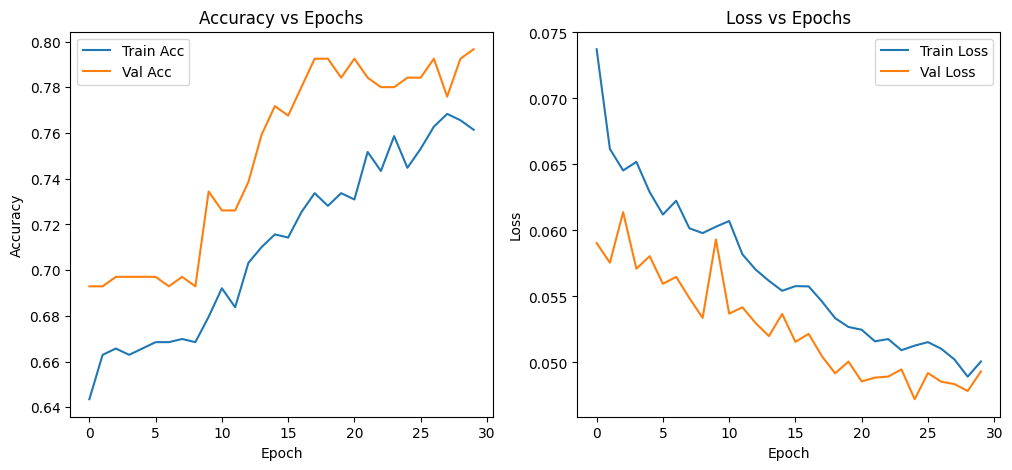

8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step


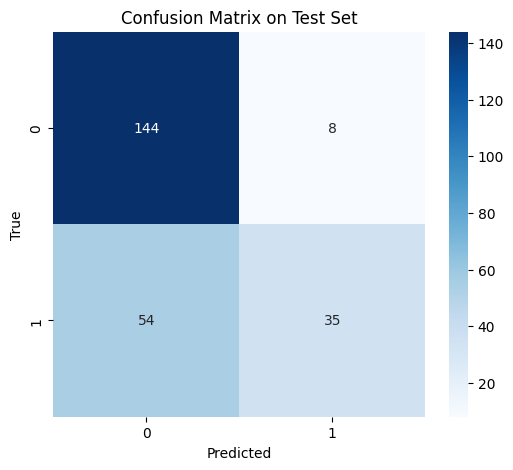

              precision    recall  f1-score   support

           0     0.7273    0.9474    0.8229       152
           1     0.8140    0.3933    0.5303        89

    accuracy                         0.7427       241
   macro avg     0.7706    0.6703    0.6766       241
weighted avg     0.7593    0.7427    0.7148       241



In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

print(classification_report(y_test, y_pred, digits=4))

# **Prediction_model**

In [ ]:
def predict_video(video_path, model, num_frames=75, img_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(frame_count // num_frames, 1)
    frames = []
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame, img_size)
        frames.append(frame)
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8))
    frames_np = np.expand_dims(np.array(frames[:num_frames]), axis=0)
    prediction = model.predict(frames_np)[0][0]
    label = 'Real' if prediction > 0.5 else 'Fake'
    return label, prediction

# Example usage:
external_video_path = '/content/drive/MyDrive/Colab Notebooks/Deepfake Video Detection/generated_2.mp4'
model1 = load_model('/content/ViT_model.h5',
custom_objects={'VitFeatureExtractor': VitFeatureExtractor})
label, score = predict_video(external_video_path, model1)
print(f"Prediction: {label}, Confi dence: {score:.4f}")

In [ ]:
def predict_folder(video_folder, model):
    results = []
    for file in os.listdir(video_folder):
        if file.endswith(".mp4"):
            video_path = os.path.join(video_folder, file)
            label, score = predict_video(video_path, model)
            results.append((file, label, score))
    return results

# Example usage:
folder_results = predict_folder("/content/drive/MyDrive/Colab Notebooks/Celeb Dataset/real", model)
for file, label, score in folder_results:
    print(f"{file}: {label} ({score:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━